<a href="https://colab.research.google.com/github/karencfisher/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df_orig = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df_orig.shape)
df_orig.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


There is still some cleaning needed. There is an 'unknown: 32' column all NaNs, so that will need be dropped. Re-encode the diagnosis feature to 1, 0. One problem has been that the k-mean cluster sometimes inverts them (which makes it hard to compare the unsupervised clustering with the actual daignoses).

In [2]:
df_orig['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [3]:
df_orig.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [4]:
df_orig.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [0]:
df_orig.drop('Unnamed: 32', axis=1, inplace=True)

In [6]:
df_orig.shape

(569, 32)

In [7]:
# Encode the diagnosis feature. We do it this way so if later the unsupervised
# clustering swaps them, this can be modified too.
df_orig['diagnosis'] = df_orig['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)
df_orig.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
# Now we'll put the diagnosis feature out of sight and work with it as unsupervised data.
df_modified = df_orig.drop('diagnosis', axis=1)
df_modified.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [0]:
def elbowPlot(df, max_k):
  '''
  Generate an elbow plot

  Inputs: the dataframe, and the maximum k
  '''
  
  sum_of_squared_distances = []
  for k in range(1, max_k + 1):
    k_means = KMeans(n_clusters=k)
    k_means.fit(df)
    sum_of_squared_distances.append(k_means.inertia_)

  plt.plot(range(1, max_k + 1), sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

In [0]:
def plot_clusters(df, column_header=None, centroids=[]):
  '''
  Make our scatterplots (one stop shooping)

  Inputs:
  df: the dataframe to plot
  column_header: specific column with clusters. If None, use third column in df
  centroids: If we are plotting those
  '''
  
  colors = ['green', 'red']
  fig, ax = plt.subplots(figsize=(8,8))

  for num in range(0, len(centroids)):
    x = centroids[num][0]
    y = centroids[num][1]
    ax.plot(x, y, 'x', color='black', linewidth=10)

  if column_header:
    grouped = df.groupby(column_header)
  else:
    grouped = df.groupby(df.columns[2])

  x = df.columns[0]
  y = df.columns[1]
  for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x=x, y=y, label=key, color=colors[key],
               alpha=.3)
  plt.show()

The original data set has 10 basic characteristics of tumors, with mean, max, and standard error value for each. It also has redundancy in the size columns (radius, perimeter, and area). For example, as shown plotting area over radius. The same was true between radius and perimeter: so the three are colinear. We'll retain just the area values

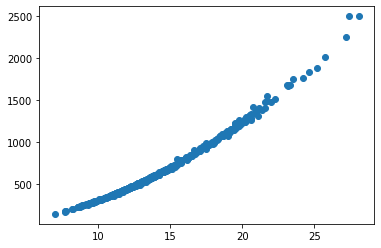

In [11]:
plt.scatter(df_modified['radius_mean'], df_modified['area_mean']);

In [12]:
columns = df_modified.columns[df_modified.columns.str.contains('radius') |
                              df_modified.columns.str.contains('perimeter')]
df_modified.drop(columns, axis=1, inplace=True)
print(df_modified.shape)
df_modified.sample(5)

(569, 25)


,id,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,texture_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
486,913102,16.85,666.0,0.08641,0.06698,0.05192,0.02791,0.1409,0.05355,1.0060,19.98,0.003535,0.01393,0.01800,0.006144,0.01254,0.001219,25.44,831.0,0.1142,0.2070,0.2437,0.07828,0.2455,0.06596
94,862028,19.83,705.6,0.10390,0.15530,0.17000,0.08815,0.1855,0.06284,0.9644,47.14,0.009250,0.03715,0.04867,0.018510,0.01498,0.003520,24.23,1025.0,0.1551,0.4203,0.5203,0.21150,0.2834,0.08234
367,9011495,18.02,458.4,0.09231,0.07175,0.04392,0.02027,0.1695,0.05916,0.7786,18.57,0.005833,0.01388,0.02000,0.007087,0.01938,0.001960,24.04,624.6,0.1368,0.2170,0.2413,0.08829,0.3218,0.07470
64,85922302,23.84,499.0,0.11220,0.12620,0.11280,0.06873,0.1905,0.06590,1.1780,36.46,0.007781,0.02648,0.02973,0.012900,0.01635,0.003601,33.47,888.3,0.1851,0.4061,0.4024,0.17160,0.3383,0.10310
9,84501001,24.04,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,1.5990,23.94,0.007149,0.07217,0.07743,0.014320,0.01789,0.010080,40.68,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750


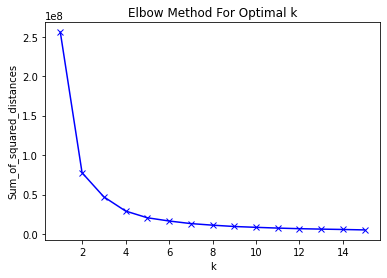

In [13]:
# Calculate Elbow plot for all the data. Slicing is to avoid the id column. 
columns = df_modified.columns[1:]
elbowPlot(df_modified[columns], 15)

In [0]:
features = ['']

Also, instead of using all three values pertaining to each tumor characteristic, we can use just the mean, and see where that takes us by itself. From the elbow plots below and above, it seems that the data will be more fully clustered in k = 2, so we'll go with just the means.

In [40]:
# Reduce data set to just the mean values. Include ID as later that will be used
# to merge in the diagnoses from the original datframe with the clustering
# results.
mean_columns = df_modified.columns[df_modified.columns.str.contains(pat='mean')]
df_means = df_modified.loc[:, mean_columns]
df_means['id'] = df_modified['id']
df_means.sample(5)

,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,id
198,22.49,1148.0,0.08523,0.14280,0.11140,0.067720,0.1767,0.05529,877486
427,21.98,359.9,0.08801,0.05743,0.03614,0.014040,0.2016,0.05977,90745
352,17.46,2010.0,0.11490,0.23630,0.33680,0.191300,0.1956,0.06121,899987
548,19.34,285.7,0.08491,0.05030,0.02337,0.009615,0.1580,0.06235,923169
480,18.03,455.3,0.09087,0.07838,0.02916,0.015270,0.1464,0.06284,912193


Correlation Matrix.

In [38]:
# Slice is to avoid including the id column
columns = df_means.columns[:-1]
df_means[columns].corr()

,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
texture_mean,1.000000,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437
area_mean,0.321086,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110
smoothness_mean,-0.023389,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792
compactness_mean,0.236702,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369
concavity_mean,0.302418,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783
concave points_mean,0.293464,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917
symmetry_mean,0.071401,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921
fractal_dimension_mean,-0.076437,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000


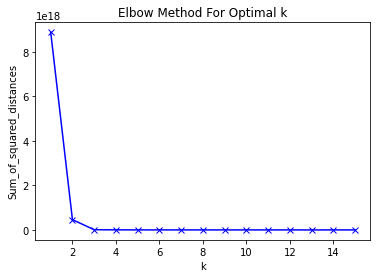

In [16]:
columns = df_means.columns[:-1]
elbowPlot(df_means, 15)

Plot some pairs of features, see what may be frutiful. We chose area and compactness. (Measure of how dense the mass is?)

Cancavity_mean and cncave points_mean seem to correlate positively highly. But they are not strictly as colinear as, for example, radius and mean, and seem to contribute towards separating malignant from benign, so they stay in.

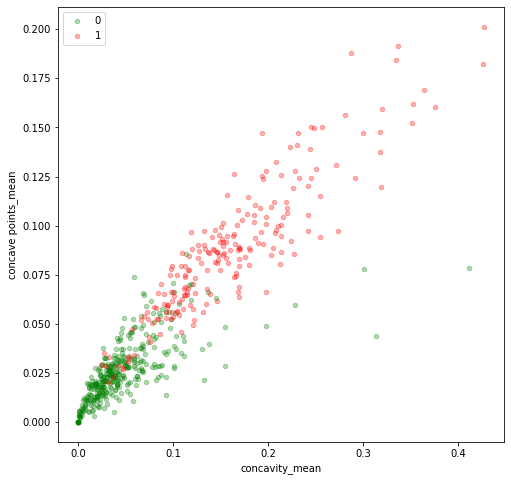

In [41]:
features = ['concavity_mean', 'concave points_mean', 'diagnosis']
plot_clusters(df_orig[features])

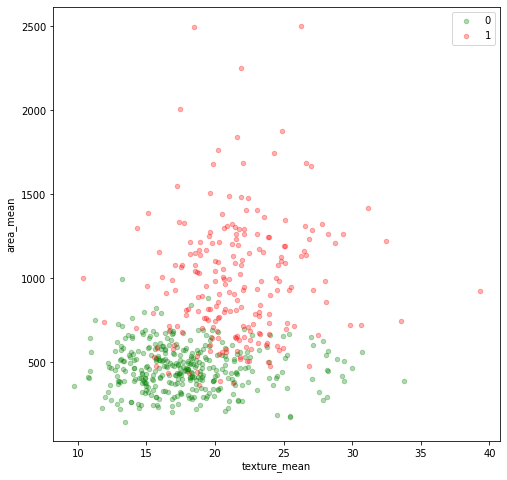

In [17]:
features = ['texture_mean', 'area_mean', 'diagnosis']
plot_clusters(df_orig[features])

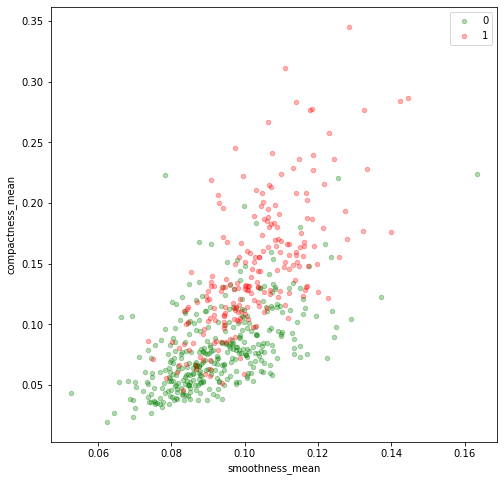

In [18]:
features = ['smoothness_mean', 'compactness_mean', 'diagnosis']
plot_clusters(df_orig[features])

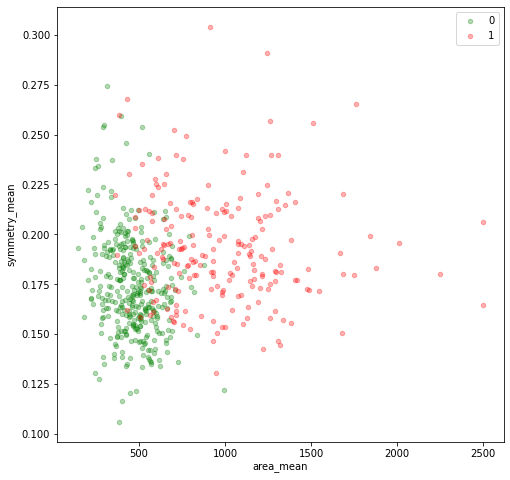

In [19]:
features = ['area_mean', 'symmetry_mean', 'diagnosis']
plot_clusters(df_orig[features])

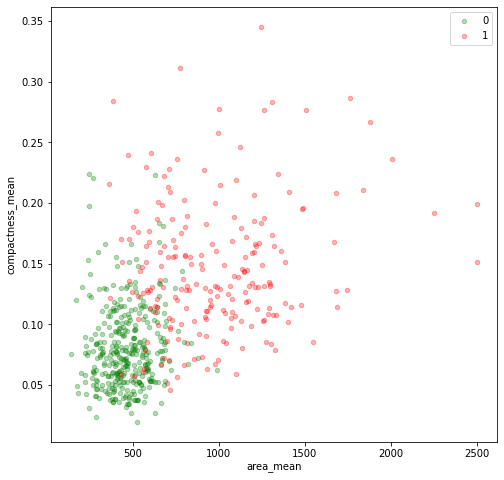

In [20]:
features = ['area_mean', 'compactness_mean', 'diagnosis']
plot_clusters(df_orig[features])

In [0]:
# Just so reusable on other cases
def kmean_cluster(df, features, k):
  df_temp = df.copy()
  model = KMeans(n_clusters=k)
  model.fit(df_temp[features])
  df_temp['clusters'] = model.labels_
  return (df_temp, model.cluster_centers_)

0    445
1    124
Name: clusters, dtype: int64


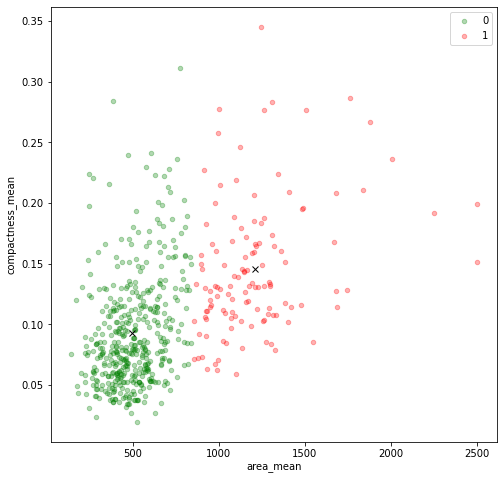

In [22]:
features = ['area_mean', 'compactness_mean']
result2 = kmean_cluster(df_means, features, 2)
print(result2[0]['clusters'].value_counts())
features.append('clusters')
plot_clusters(result2[0][features], 'clusters', result2[1])

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [0]:
def accuracy(df_predict, df_actual):
  '''
  Get accuracy in 'retrospect' 

  Inputs: the clustered dataframe and the original dataframe
  Output: display confusion matrix and false negative rate
  '''

  # merge relevant data between the two to match actual vs. predicted clusters
  revealed = pd.merge(df_predict[['id', 'clusters']], df_actual[['id', 'diagnosis']], 
                      on='id', how='inner')
  
  # Generate and display confusion matrix
  confusion_matrix = pd.crosstab(revealed['diagnosis'], revealed['clusters'], margins=True)
  print(f'Confusion-matrix:\n{confusion_matrix}\n')

  # Calculate false negative rate and print 
  true_positives = confusion_matrix.loc[1][1] / confusion_matrix.loc[1]['All']
  false_negatives = confusion_matrix.loc[1][0] /confusion_matrix.loc[1]['All']
  print(f' True positive rate = {round(true_positives * 100, 3)}%\n',
                    f'False negative rate = {round(false_negatives * 100, 3)}%')

In [24]:
accuracy(result2[0], df_orig)

Confusion-matrix:
clusters     0    1  All
diagnosis               
0          355    2  357
1           90  122  212
All        445  124  569

 True positive rate = 57.547%
 False negative rate = 42.453%


It misses quite a few malignant examples, as above. The model only accurately classifies malignant cases by just over 57.5% of the time.

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [25]:
df_means.head()

,texture_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,id
0,10.38,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,842302
1,17.77,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,842517
2,21.25,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,84300903
3,20.38,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,84348301
4,14.34,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,84358402


In [26]:
##### Your Code Here #####
scaler = StandardScaler()
normalized = scaler.fit_transform(df_means[:-1])
pd.DataFrame(normalized).head()

,0,1,2,3,4,5,6,7,8
0,-2.072088,0.982711,1.575100,3.282432,2.651483,2.531580,2.215435,2.253401,-0.236636
1,-0.351635,1.907712,-0.838892,-0.489238,-0.025814,0.546209,-0.000051,-0.869117,-0.236634
2,0.458538,1.557635,0.943991,1.051202,1.361810,2.036076,0.937972,-0.398755,0.430957
3,0.255995,-0.767391,3.303478,3.401861,1.914348,1.450246,2.865116,4.906975,0.431337
4,-1.150167,1.825174,0.277023,0.537469,1.369344,1.427019,-0.011001,-0.563098,0.431417


In [27]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized)
pca_table = pd.DataFrame(pca_data, columns=['PC1', 'PC2'])
pca_table.head()

,PC1,PC2
0,5.586636,2.041816
1,0.040897,-1.736911
2,3.088244,-1.239733
3,6.061005,4.588028
4,1.856052,-1.283730


0    393
1    175
Name: clusters, dtype: int64


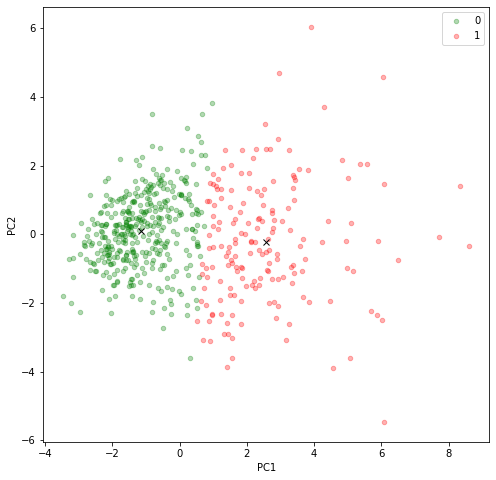

In [33]:
features = pca_table.columns.tolist()
result = kmean_cluster(pca_table, features, 2)
print(result[0]['clusters'].value_counts())
features.append('clusters')
plot_clusters(result[0][features], 'clusters', result[1])

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

In [34]:
result[0]['id'] = df_means['id']
accuracy(result[0], df_orig)

Confusion-matrix:
clusters     0    1  All
diagnosis               
0          335   21  356
1           58  154  212
All        393  175  568

 True positive rate = 72.642%
 False negative rate = 27.358%


After normalizing the data and applying Principal Component Analysis, the model fare a little better, missine just over 27% of the time.

We can see if more components would produce better clustering.


In [0]:
from matplotlib.ticker import MaxNLocator

In [0]:
def countPCs(data, nmax):
  '''
  See how many components are needed to explain the variance for at least 90% 
  of the data

  input
  data: raw data for PCA  
  nmax: maximum components to calculate
  '''
  # instantiate and fit the PCA
  pca4 = PCA(n_components=nmax)
  pca4_data = pca4.fit_transform(data)

  # We'll need a list of columns
  columns = []
  for i in range(1, nmax + 1):
    columns.append(f'PC{i}')

  # make it into a table
  pca4_table = pd.DataFrame(pca4_data, columns=columns)
  
  # Produce the scree plot
  ax = plt.figure(figsize=(10,5)).gca()
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  variances = pca4.explained_variance_ratio_
  x_vals = range(1, len(pca4_table.columns) + 1)
  ax.plot(x_vals, variances, '-o')
  plt.title("Scree plot")
  plt.xlabel('Component')
  plt.ylabel('Variances explained')
  plt.show()

  # Sum the scores until >= 90%. A classic greedy algorithm. ;)
  total = 0
  list_components = []
  for i, col in enumerate(pca4_table.columns[:-1]):
    total += variances[i]
    list_components.append(col)
    if total >= .9:
      break

  # Print the findings
  print(f'{list_components[0]} through {list_components[-1]} account for {total \
                                                * 100}% of the data.')

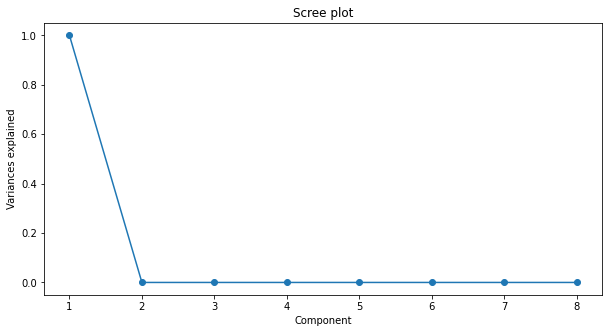

PC1 through PC1 account for 99.99999999921499% of the data.


In [32]:
countPCs(df_means, 8)

Looks like we'd be good at just one even.

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project